## Homework 22: Size Reduction Methods
**Conditions**:
- Dataset: Abalone
- Metric: Accuracy + MSE

**Goal**: check how size reductions method influences on models metrics such as accuracy (classification task) and MSE (regression task)

**Acceptance criteria**: None - training only

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from ucimlrepo import fetch_ucirepo
from hyperopt import fmin, tpe, hp, Trials, space_eval

# CLASSIFICATION TASK

1. **Data preparation**:
     - Load a dataset containing multidimensional data.
     - Divide the data into training and test sets.

**Abalone Dataset**

Dataset Information

Additional Information

Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).

In [2]:
# fetch dataset 
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes) 
features = abalone.data.features
target = abalone.data.targets

In [3]:
data = features.copy()
data['Rings'] = target

In [4]:
data

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [5]:
info = pd.DataFrame(data.isnull().sum(),columns=["IsNull"])
info.insert(1,"IsNa",data.isna().sum(),True)
info.insert(2,"Duplicate",data.duplicated().sum(),True)
info.insert(3,"Unique",data.nunique(),True)
info.insert(4,"Min",data.min(),True)
info.insert(5,"Max",data.max(),True)
info.T

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
IsNull,0,0,0,0,0,0,0,0,0
IsNa,0,0,0,0,0,0,0,0,0
Duplicate,0,0,0,0,0,0,0,0,0
Unique,3,134,111,51,2429,1515,880,926,28
Min,F,0.075,0.055,0.0,0.002,0.001,0.0005,0.0015,1
Max,M,0.815,0.65,1.13,2.8255,1.488,0.76,1.005,29


In [6]:
data.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Let's change target from 'Rings' to 'Sex' -> so it will be classification task
Also, need to change 'M', 'I', 'F' from 'Sex' column to 0,1,2

In [7]:
data['Sex'].value_counts()

Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64

In [8]:
map_conditions = {
    "M": 0,
    "I": 1,
    "F": 2
}

data['Sex'] = data['Sex'].map(map_conditions)

In [9]:
data['Sex'].value_counts()

Sex
0    1528
1    1342
2    1307
Name: count, dtype: int64

In [10]:
X = data.drop('Sex', axis=1)
y = data['Sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

2. **Research of initial data**:
- Visualize data in source space. If you have more than 3 features, select 2 or 3 of them to display.
- Assess the distribution of the data: are there any clusters or outliers?

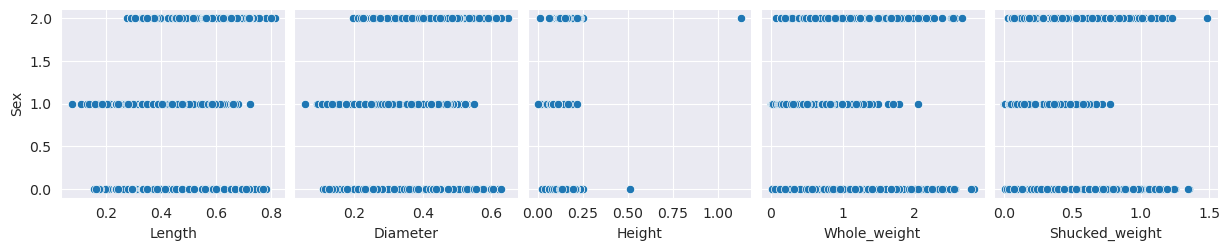

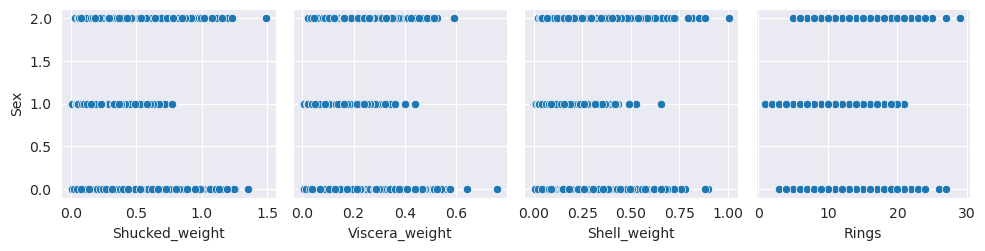

In [11]:
for i in range(1, len(data.columns), 4):
    sns.pairplot(data=data, x_vars=data.columns[i: i+5], y_vars=['Sex'])

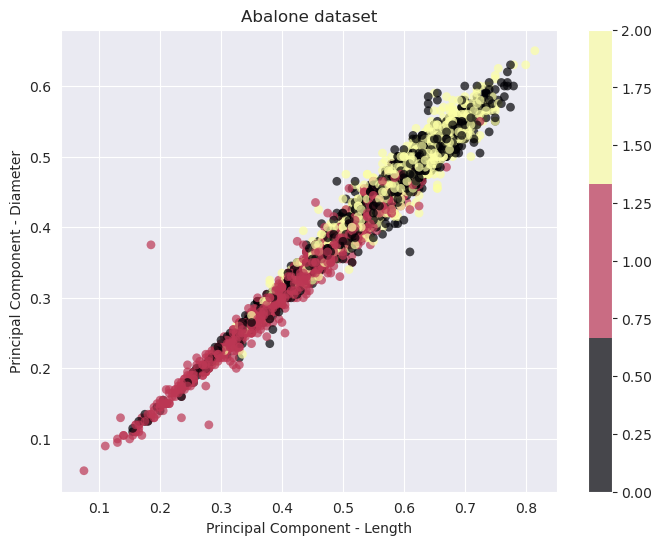

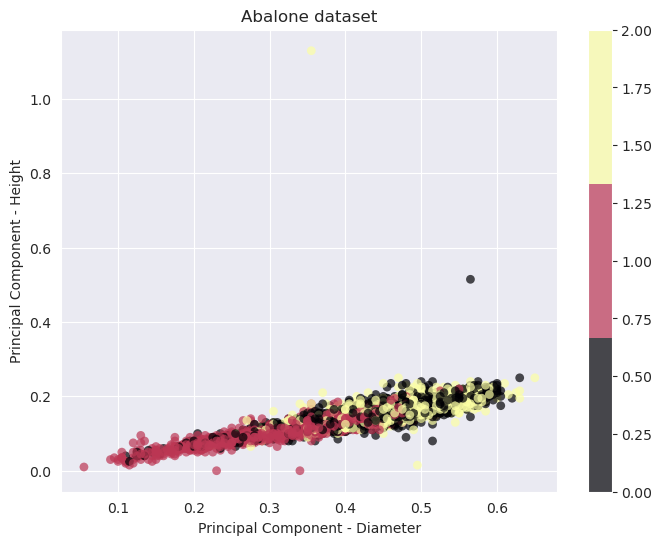

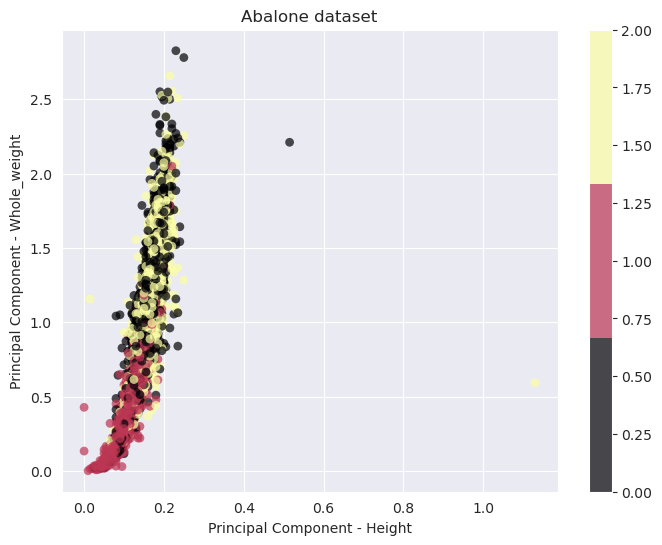

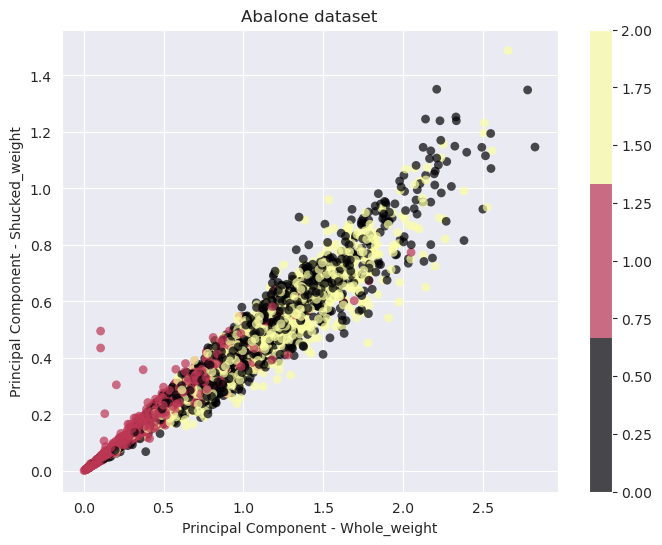

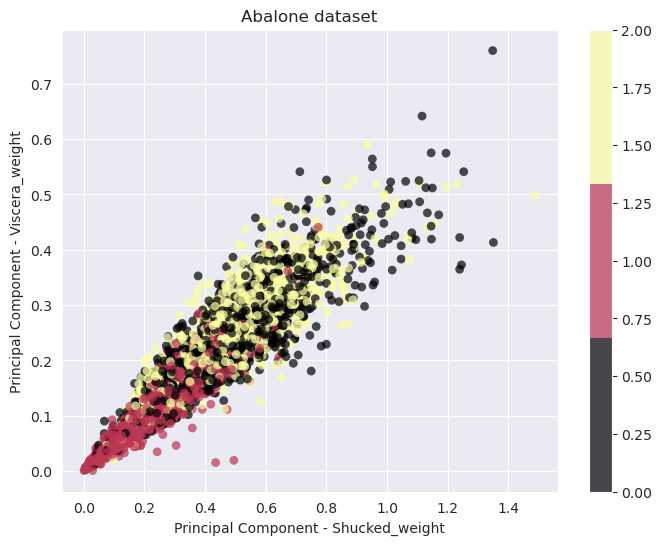

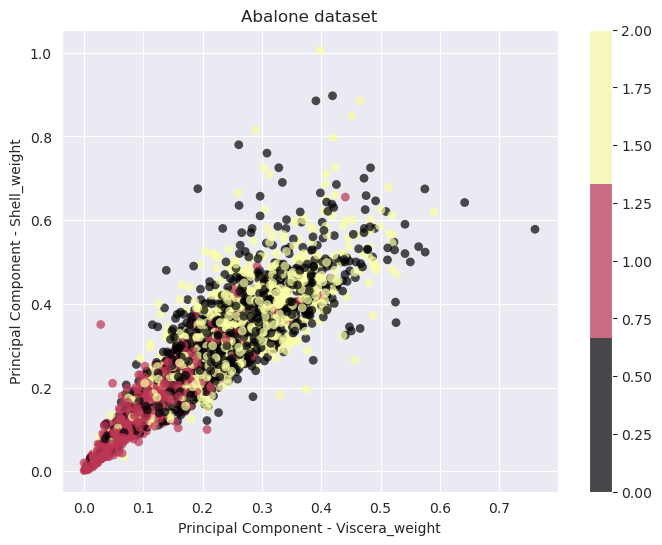

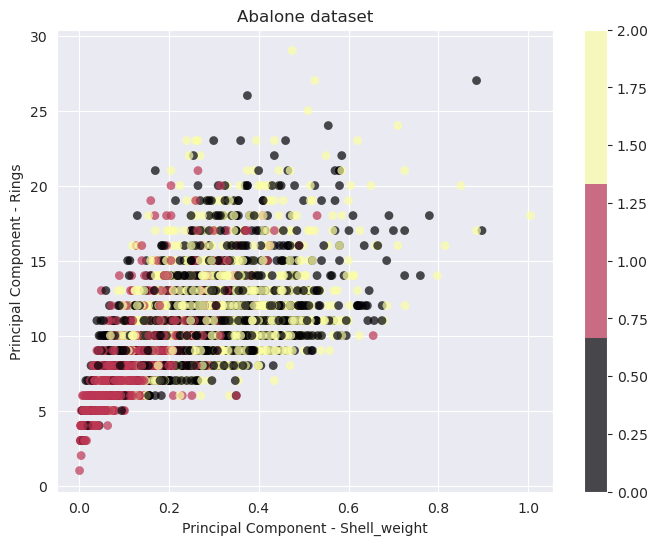

In [12]:
for i in range(1, len(X.columns)):
    plt.figure(figsize=(8,6))
    plt.scatter(X.iloc()[:, i-1], X.iloc[:, i], c=y, edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('inferno', 3))
    plt.colorbar()
    plt.title('Abalone dataset')
    plt.xlabel(f'Principal Component - {X.columns[i-1]}')
    plt.ylabel(f'Principal Component - {X.columns[i]}')
    plt.show()

## PCA

1. **Application of PCA**:
- Apply PCA to the entire dataset to calculate the principal components.
- Visualize the proportion of variance explained as a function of the number of principal components.
- Determine the minimum number of components required to retain 95% of the original variance.

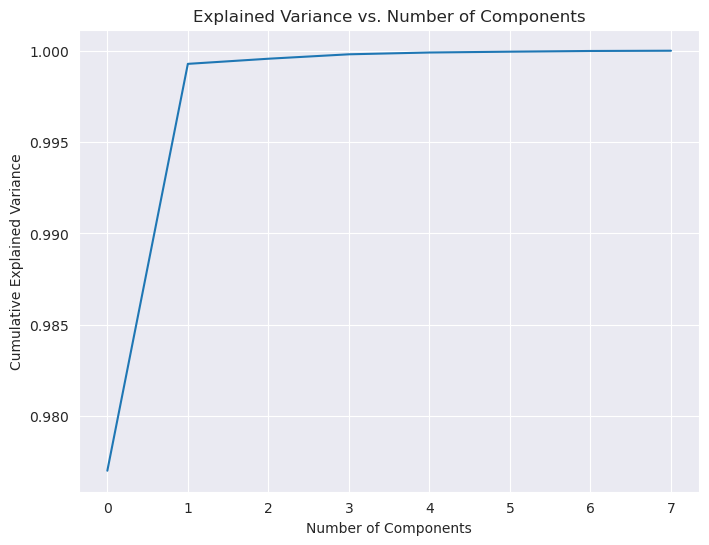

In [13]:
pca = PCA().fit(X)

# Визуализация
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

Min number of components to save 95% of information is 1, but 2 is better

2. **Dimensionality reduction**:
- Apply PCA with the selected number of components.
- Visualize transformed data in new principal component space.

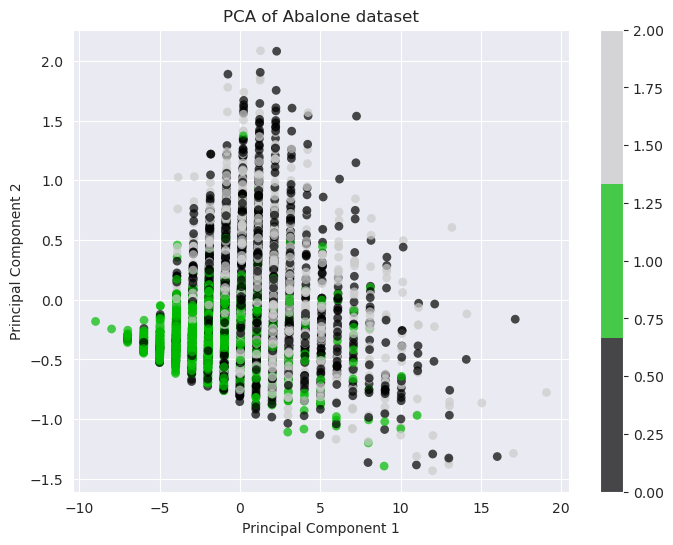

In [14]:
pca = PCA(n_components=2)

# Applying PCA
X_transformed = pca.fit_transform(X)

# Visualization
plt.figure(figsize=(8,6))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 3))
plt.colorbar()
plt.title('PCA of Abalone dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

3. **Performance assessment** (optional):
- Train a simple model (eg logistic regression) on the original data and on the data after dimensionality reduction using PCA.
- Compare quality metrics on the test set for both models. Has quality improved after using PCA?

In [15]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [16]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"Logistic Regression Accuracy for the whole dataset: {accuracy_score(y_test, y_pred):.2f}")

lr_pca = LogisticRegression(penalty='l1', solver='liblinear')
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)
print(f"PCA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_pca):.2f}")

Logistic Regression Accuracy for the whole dataset: 0.56
PCA-based Logistic Regression Accuracy: 0.56


## LDA

1. **Application of LDA**
- Apply LDA to the training set and reduce the dimension to 2.
- Visualize 2D data using different colors for different classes.

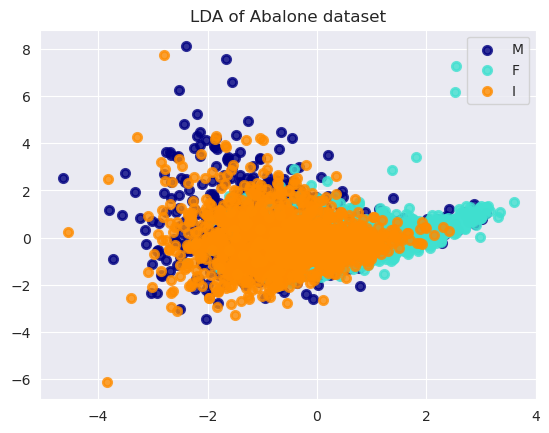

In [17]:
target_names = ['M', 'F', 'I']
lda = LDA(n_components=2)
X_r2 = lda.fit_transform(X, y)

colors = ['navy', 'turquoise', 'darkorange']
lw = 2

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of Abalone dataset')

plt.show()

2. **Classification using LDA**
- Using the transformed features, train a classifier (for example, logistic regression) on the training set.
- Check the accuracy of the classifier on a test sample.

In [18]:
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

lr_lda = LogisticRegression(penalty='l1', solver='liblinear')
lr_lda.fit(X_train_lda, y_train)
y_pred_lda = lr_lda.predict(X_test_lda)
print(f"LDA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lda):.2f}")

LDA-based Logistic Regression Accuracy: 0.55


3. **Comparison with PCA**
- Apply PCA to the same data set and reduce the dimensionality to 2.
- Visualize the results and then train and test the classifier, just like with LDA.
- Compare visual results and classification quality metrics for LDA and PCA.

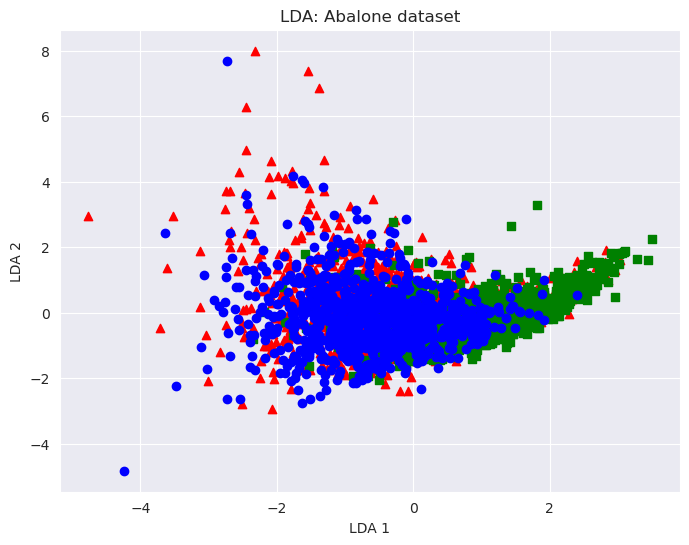

LDA-based Logistic Regression Accuracy: 0.55


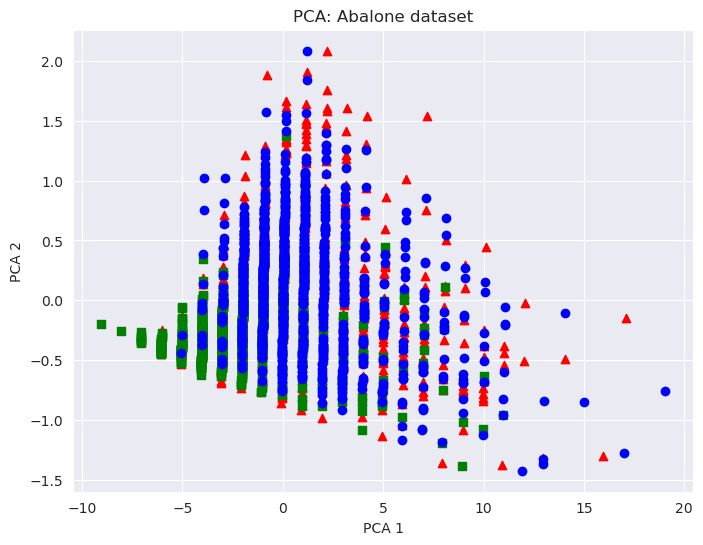

PCA-based Logistic Regression Accuracy: 0.56


In [19]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

plt.figure(figsize=(8, 6))
for label, marker, color in zip(range(3), ('^', 's', 'o'), ('red', 'green', 'blue')):
    plt.scatter(X_train_lda[y_train == label, 0],
                X_train_lda[y_train == label, 1],
                marker=marker, color=color)
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.title('LDA: Abalone dataset')
plt.show()

lr_lda = LogisticRegression(penalty='l1', solver='liblinear')
lr_lda.fit(X_train_lda, y_train)
y_pred_lda = lr_lda.predict(X_test_lda)
print(f"LDA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lda):.2f}")

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(8, 6))
for label, marker, color in zip(range(3), ('^', 's', 'o'), ('red', 'green', 'blue')):
    plt.scatter(X_train_pca[y_train == label, 0],
                X_train_pca[y_train == label, 1],
                marker=marker, color=color)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA: Abalone dataset')
plt.show()

lr_pca = LogisticRegression(penalty='l1', solver='liblinear')
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)
print(f"PCA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_pca):.2f}")

## TSNE

Apply PCA to reduce the dimension to 2 components and visualize the result.
Apply t-SNE to reduce the dimensionality to 2 components and visualize the result.
Compare visualizations and draw conclusions about the superiority of t-SNE over PCA on a given dataset.

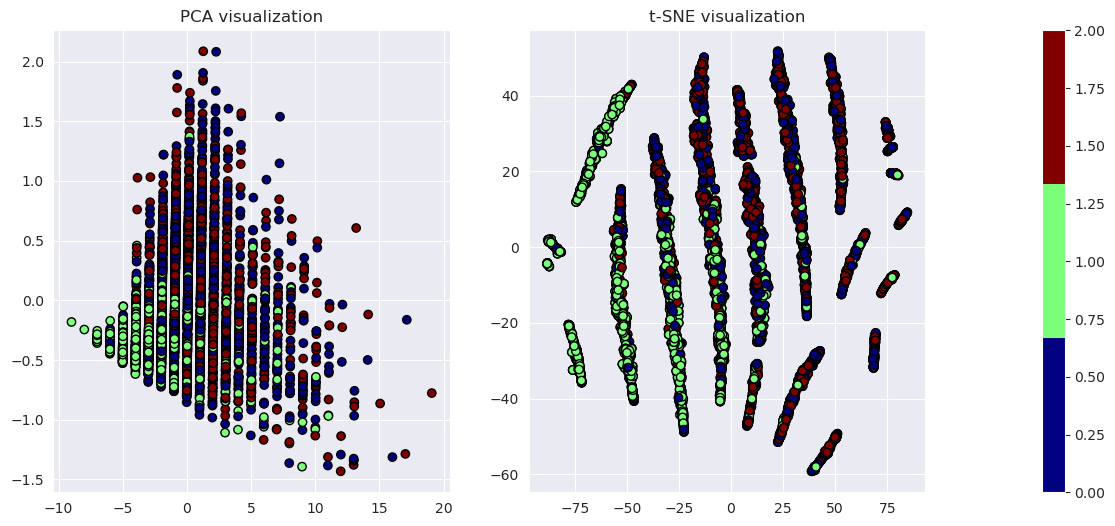

In [20]:
X_pca = PCA(n_components=2).fit_transform(X)

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='k', cmap=plt.cm.get_cmap('jet', 3))
axes[0].set_title('PCA visualization')

axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, edgecolors='k', cmap=plt.cm.get_cmap('jet', 3))
axes[1].set_title('t-SNE visualization')

plt.colorbar(mappable=axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, edgecolors='k', cmap=plt.cm.get_cmap('jet', 3)), ax=axes, orientation='vertical', pad=0.1)
plt.show()

# REGRESSION TASK

In [21]:
data2 = features.copy()

In [22]:
data2

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


In [23]:
data_encoded = pd.get_dummies(data2, columns=['Sex'], dtype=int)

In [24]:
data_encoded

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0,1,0
...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,1,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,0,0,1
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,0,0,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,1,0,0


In [25]:
data_encoded['Rings'] = target

In [26]:
data_encoded

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_F,Sex_I,Sex_M,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,0,0,1,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0,0,1,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,1,0,0,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,0,0,1,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,1,0,0,11
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,0,0,1,10
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,0,0,1,9
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,1,0,0,10


In [27]:
X = data_encoded.drop('Rings', axis=1)
y = data_encoded['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Let's define a function to get tuned hyperparameters

In [28]:
def get_tuned_params(some_X, some_y):

    # Define the hyperparameter search space
    space = {
        'n_estimators': hp.quniform('n_estimators', 50, 200, 1),  # Number of trees
        'max_depth': hp.quniform('max_depth', 2, 20, 1),  # Maximum depth of each tree
        'min_samples_split': hp.uniform('min_samples_split', 0.01, 0.5),  # Minimum samples required to split a node
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5),  # Minimum samples required in a leaf node
    }

    # Define the objective function (minimize mean squared error)
    def objective(params):
        regressor = RandomForestRegressor(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=42  # Set a random seed for reproducibility
        )
        # Use cross-validation to estimate performance
        mse_scores = -cross_val_score(regressor, some_X, some_y, cv=5, scoring='neg_mean_squared_error')
        return np.mean(mse_scores)

    # Perform hyperparameter optimization
    trials = Trials()  # Keep track of optimization results
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

    best['max_depth'] = int(best['max_depth'])
    best['n_estimators'] = int(best['n_estimators'])
    
    return best

1. The whole dataset

In [29]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE for the whole dataset: {mean_squared_error(y_test, y_pred):.2f}")

params = get_tuned_params(X_train, y_train)
tuned_regr = RandomForestRegressor(**params)
tuned_regr.fit(X_train, y_train)
y_pred = tuned_regr.predict(X_test)
print(f"MSE for the whole dataset + tuned hyperparameters: {mean_squared_error(y_test, y_pred):.2f}")

MSE for the whole dataset: 4.84
100%|██████████| 100/100 [04:09<00:00,  2.49s/trial, best loss: 4.835909724589996]
MSE for the whole dataset + tuned hyperparameters: 4.76


# PCA

In [30]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

regr = RandomForestRegressor()
regr.fit(X_train_pca, y_train)
y_pred = regr.predict(X_test_pca)
print(f"MSE for the PCA-reduced dataset: {mean_squared_error(y_test, y_pred):.2f}")

params = get_tuned_params(X_train_pca, y_train)
tuned_regr = RandomForestRegressor(**params)
tuned_regr.fit(X_train_pca, y_train)
y_pred = tuned_regr.predict(X_test_pca)
print(f"MSE for the PCA-reduced dataset + tuned hyperparameters: {mean_squared_error(y_test, y_pred):.2f}")

MSE for the PCA-reduced dataset: 6.80
100%|██████████| 100/100 [03:19<00:00,  1.99s/trial, best loss: 6.96964537878201]
MSE for the PCA-reduced dataset + tuned hyperparameters: 6.47


# LDA

In [31]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

regr = RandomForestRegressor()
regr.fit(X_train_lda, y_train)
y_pred = regr.predict(X_test_lda)
print(f"MSE for the LDA-reduced dataset: {mean_squared_error(y_test, y_pred):.2f}")

params = get_tuned_params(X_train_lda, y_train)
tuned_regr = RandomForestRegressor(**params)
tuned_regr.fit(X_train_lda, y_train)
y_pred = tuned_regr.predict(X_test_lda)
print(f"MSE for the LDA-reduced dataset + tuned hyperparameters: {mean_squared_error(y_test, y_pred):.2f}")

MSE for the LDA-reduced dataset: 5.38
100%|██████████| 100/100 [02:50<00:00,  1.70s/trial, best loss: 4.543947350976406]
MSE for the LDA-reduced dataset + tuned hyperparameters: 4.54


# TSNE

In [32]:
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train, y_train)
X_test_tsne = tsne.fit_transform(X_test, y_test)


regr = RandomForestRegressor()
regr.fit(X_train_tsne, y_train)
y_pred = regr.predict(X_test_tsne)
print(f"MSE for the TSNE-reduced dataset: {mean_squared_error(y_test, y_pred):.2f}")

params = get_tuned_params(X_train_tsne, y_train)
tuned_regr = RandomForestRegressor(**params)
tuned_regr.fit(X_train_tsne, y_train)
y_pred = tuned_regr.predict(X_test_tsne)
print(f"MSE for the TSNE-reduced dataset + tuned hyperparameters: {mean_squared_error(y_test, y_pred):.2f}")

MSE for the TSNE-reduced dataset: 8.20
100%|██████████| 100/100 [02:53<00:00,  1.74s/trial, best loss: 5.522670242174014]
MSE for the TSNE-reduced dataset + tuned hyperparameters: 6.94
